<a href="https://colab.research.google.com/github/revengeWillBeTaken/ML-ops/blob/master/BloomsTaxonomy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Mar 23 17:14:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    61W / 149W |   8362MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install keras tf-models-official pydot graphviz 

In [ ]:
!pip install tensorflow_hub

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import tensorflow_hub as hub
from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir("/content/drive/MyDrive/Data")
!ls

 model.png	    'Testing Data.xlsx'  'Training Data.xlsx'
'Testing Data.csv'  'Training Data.csv'


In [ ]:
trainDf=pd.read_csv("/content/drive/MyDrive/Data/Training Data.csv");
testDf=pd.read_csv("/content/drive/MyDrive/Data/Testing Data.csv");

In [ ]:
trainDf.isnull().sum()

Number       0
Question    76
Level       76
dtype: int64

In [ ]:
trainDf.dropna(inplace=True)

In [ ]:
trainDf.isnull().sum()

Number      0
Question    0
Level       0
dtype: int64

In [ ]:
trainDf["Level"].value_counts()

Knowledge      117
Analysis       114
Synthesis      112
Application    111
Understand     110
Evaluation     104
Name: Level, dtype: int64

In [ ]:
trainDf.head()

,Number,Question,Level
0,1,What did the policy propose?,Knowledge
1,2,Who supported the policy?,Knowledge
2,3,When was the bill passed?,Knowledge
3,4,What events influenced the passage of the bill?,Knowledge
4,5,In your own words define aging-in-place.,Understand


In [ ]:
trainDf['Question'].astype(str)

0                           What did the policy propose?
1                              Who supported the policy?
2                              When was the bill passed?
3        What events influenced the passage of the bill?
4               In your own words define aging-in-place.
                             ...                        
663                What do you think is the mass and why
664    What do you think are the strengths of using i...
665    Do you think that this statement conveys the i...
666    How do you think the community should grow or ...
667    How Do You Think One Should Reason in Making E...
Name: Question, Length: 668, dtype: object

In [ ]:
trainDf['Level'].astype(str)

0       Knowledge
1       Knowledge
2       Knowledge
3       Knowledge
4      Understand
          ...    
663    Evaluation
664    Evaluation
665    Evaluation
666    Evaluation
667    Evaluation
Name: Level, Length: 668, dtype: object

In [ ]:
trainDf.dtypes

Number       int64
Question    object
Level       object
dtype: object

In [ ]:
oneHotColumns = pd.get_dummies(trainDf['Level'])
trainDf=pd.concat([trainDf, oneHotColumns], axis=1)

In [ ]:
trainDf.head()

,Number,Question,Level,Analysis,Application,Evaluation,Knowledge,Synthesis,Understand
0,1,What did the policy propose?,Knowledge,0,0,0,1,0,0
1,2,Who supported the policy?,Knowledge,0,0,0,1,0,0
2,3,When was the bill passed?,Knowledge,0,0,0,1,0,0
3,4,What events influenced the passage of the bill?,Knowledge,0,0,0,1,0,0
4,5,In your own words define aging-in-place.,Understand,0,0,0,0,0,1


In [ ]:
bertLayer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/1",trainable=True)
bertLayer

In [ ]:
vocabFile=bertLayer.resolved_object.vocab_file.asset_path.numpy();
doLowerCase=bertLayer.resolved_object.do_lower_case.numpy();
tokenizer=tokenization.FullTokenizer(vocab_file=vocabFile,do_lower_case=doLowerCase);

In [ ]:
doLowerCase

False

In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]','[SEP]'])

[101, 102]

In [ ]:
def encodeName(n):
  tokens=list(tokenizer.tokenize(n));
  tokens.append('[SEP]');
  return tokenizer.convert_tokens_to_ids(tokens);

questions=tf.ragged.constant([encodeName(n) for n in trainDf['Question']])

In [ ]:
questions

<tf.RaggedTensor [[12489, 12172, 10105, 14368, 30027, 136, 102], [14516, 19992, 10105, 14368, 136, 102], [12242, 10134, 10105, 34497, 20006, 136, 102], [12489, 15284, 31377, 10105, 22718, 10108, 10105, 34497, 136, 102], [10167, 20442, 12542, 21296, 39224, 16942, 10230, 118, 10106, 118, 11192, 119, 102], [12271, 100620, 19181, 31237, 18757, 42074, 12229, 14854, 10114, 12962, 10106, 10455, 12542, 14154, 119, 102], [13810, 99590, 11044, 14796, 169, 11284, 77229, 11942, 67701, 13065, 10894, 11424, 10106, 10531, 13474, 119, 102], [14962, 20970, 11354, 16357, 14154, 10590, 51371, 10106, 10105, 13648, 10107, 136, 102], [23525, 40843, 20970, 10531, 48515, 136, 102], [27746, 88975, 14796, 10464, 20970, 11760, 102], [12489, 19513, 10105, 16942, 10230, 13736, 10406, 31444, 10114, 100062, 10531, 13170, 136, 102], [24781, 20970, 41512, 10425, 11249, 62729, 10105, 11760, 10108, 76917, 10336, 11354, 16357, 136, 102], [14962, 12174, 10105, 10106, 25907, 24407, 10347, 13486, 76585, 10114, 13145, 10106,

In [ ]:
questions[0]

<tf.Tensor: shape=(7,), dtype=int32, numpy=array([12489, 12172, 10105, 14368, 30027,   136,   102], dtype=int32)>

In [ ]:
len(trainDf['Level'])

668

In [ ]:
questions.shape

TensorShape([668, None])

In [ ]:
tokenizedQuestion=tokenizer.tokenize(trainDf['Question'][0])
for i in tokenizedQuestion:
  print(i,tokenizer.convert_tokens_to_ids([i]))

What [12489]
did [12172]
the [10105]
policy [14368]
propose [30027]
? [136]


In [ ]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*questions.shape[0]
input_word_ids = tf.concat([cls, questions], axis=-1)

In [ ]:
input_word_ids

<tf.RaggedTensor [[101, 12489, 12172, 10105, 14368, 30027, 136, 102], [101, 14516, 19992, 10105, 14368, 136, 102], [101, 12242, 10134, 10105, 34497, 20006, 136, 102], [101, 12489, 15284, 31377, 10105, 22718, 10108, 10105, 34497, 136, 102], [101, 10167, 20442, 12542, 21296, 39224, 16942, 10230, 118, 10106, 118, 11192, 119, 102], [101, 12271, 100620, 19181, 31237, 18757, 42074, 12229, 14854, 10114, 12962, 10106, 10455, 12542, 14154, 119, 102], [101, 13810, 99590, 11044, 14796, 169, 11284, 77229, 11942, 67701, 13065, 10894, 11424, 10106, 10531, 13474, 119, 102], [101, 14962, 20970, 11354, 16357, 14154, 10590, 51371, 10106, 10105, 13648, 10107, 136, 102], [101, 23525, 40843, 20970, 10531, 48515, 136, 102], [101, 27746, 88975, 14796, 10464, 20970, 11760, 102], [101, 12489, 19513, 10105, 16942, 10230, 13736, 10406, 31444, 10114, 100062, 10531, 13170, 136, 102], [101, 24781, 20970, 41512, 10425, 11249, 62729, 10105, 11760, 10108, 76917, 10336, 11354, 16357, 136, 102], [101, 14962, 12174, 1010

In [ ]:
lens=[len(i) for i in input_word_ids]

In [ ]:
max_seq_length=max(lens)
print("The maximum length is ",max_seq_length)

The maximum length is  47


In [ ]:
max_seq_length=int(2.5*max_seq_length)
print("The maximum length is ",max_seq_length)

The maximum length is  117


In [ ]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs



In [ ]:
X_train = bert_encode(trainDf['Question'], tokenizer, max_seq_length)

In [ ]:
X_train['input_word_ids'].shape

TensorShape([668, 117])

In [ ]:
num_class = 6  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bertLayer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

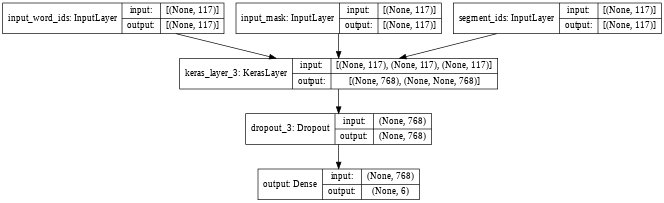

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [ ]:
oneHotColumns

,Analysis,Application,Evaluation,Knowledge,Synthesis,Understand
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,0,0,0,1,0,0
3,0,0,0,1,0,0
4,0,0,0,0,0,1
...,...,...,...,...,...,...
663,0,0,1,0,0,0
664,0,0,1,0,0,0
665,0,0,1,0,0,0
666,0,0,1,0,0,0


In [ ]:
epochs = 7
batch_size = 16  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(oneHotColumns)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:


model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 117)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 117)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 117)]        0                                            
__________________________________________________________________________________________________
keras_layer_3 (KerasLayer)      [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [ ]:
history = model.fit(X_train,
                    oneHotColumns,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1)

Epoch 1/7
42/42 [==============================] - 44s 831ms/step - loss: 0.0032 - accuracy: 0.9996
Epoch 2/7
42/42 [==============================] - 35s 837ms/step - loss: 0.0117 - accuracy: 0.9975
Epoch 3/7
42/42 [==============================] - 35s 838ms/step - loss: 0.0227 - accuracy: 0.9943
Epoch 4/7
42/42 [==============================] - 35s 838ms/step - loss: 0.0069 - accuracy: 0.9997
Epoch 5/7
42/42 [==============================] - 35s 838ms/step - loss: 3.6448e-04 - accuracy: 1.0000
Epoch 6/7
42/42 [==============================] - 35s 838ms/step - loss: 0.0016 - accuracy: 0.9994
Epoch 7/7
42/42 [==============================] - 35s 837ms/step - loss: 8.6223e-04 - accuracy: 1.0000


In [ ]:
loss, accuracy = model.evaluate(X_train, oneHotColumns, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 1.0000


In [ ]:
import re

In [ ]:
def cleanHtml(rawText):
  clean=re.compile("<.*?>");
  cleanText=re.sub(clean,"",rawText);
  return cleanText

In [ ]:
testDf.isnull().sum()

Number      0
Question    0
Level       0
dtype: int64

In [ ]:
testDf.dropna(inplace=True)

In [ ]:
testDf.head()

,Number,Question,Level
0,1,In the movie recommendation system example the...,Analysis/
1,2,Prediction is done by doing a dot product of t...,Analysis/Understand
2,3,"Hi Harshit, I would have had no issues if the ...",Analysis/understand
3,4,"Hi Akbar,Really Sorry, I hadnt noticed this. Y...",Understand


In [ ]:
testDf['Question']=testDf['Question'].apply(cleanHtml)

In [ ]:
testDf

,Number,Question,Level
0,1,In the movie recommendation system example the...,Analysis/
1,2,Prediction is done by doing a dot product of t...,Analysis/Understand
2,3,"Hi Harshit, I would have had no issues if the ...",Analysis/understand
3,4,"Hi Akbar,Really Sorry, I hadnt noticed this. Y...",Understand


In [ ]:
testDf['Question'][0]

"In the movie recommendation system example the test data with its ratings is used to predict the same test data. Isn't this wrong. The target variable should never be used to predict itself."

In [ ]:
testDf['Question'][1]

'Prediction is done by doing a dot product of the user correlation (for user based model) and the ratings made by user (using the train dataset).Test Data is used for the Evaluation purpose. The predictions made&nbsp;(predictions matrix got above) are evaluated on this test data set to evaluate how good or bad the performance of the model is and which model should be deployed.Hope that helps.'

In [ ]:
testDf['Question'][2]

"Hi Harshit, I would have had no issues if the predictions made on the train dataset were used for evaluation. But, this is not what was done. Please go through the movie recommendation system example's Evaluation section. The model is trained on the test&nbsp;dataset and evaluated. This is what my problem is with the methodology.&nbsp;"

In [ ]:
testDf['Question'][3]

'Hi Akbar,Really Sorry, I hadnt noticed this. You have a very valid question.&nbsp;Lets wait for the TAs to respond.@TA Please clarify this.If the Test set is being used for generating the predictions and evaluation is done using these predictions,then what is the even need of having the Train dataset?? what is the need of generating prediction ratings using train dataset?Please clarify.thank you.'

In [ ]:
X_test = bert_encode(testDf['Question'], tokenizer, max_seq_length)

In [ ]:
max_seq_length

117

In [ ]:
y=model.predict(X_test)

In [ ]:
y

array([[3.3233302e-06, 9.9985003e-01, 3.6101719e-05, 1.0196187e-06,
        4.1705593e-05, 6.7831861e-05],
       [9.0463748e-03, 8.0950066e-02, 8.9724189e-01, 4.5412624e-05,
        1.2649169e-02, 6.6990680e-05],
       [2.9469671e-04, 2.5798636e-03, 9.8251396e-01, 8.1504813e-06,
        1.1386925e-02, 3.2162941e-03],
       [1.6025032e-06, 8.7841463e-06, 9.9986351e-01, 1.0564056e-06,
        1.6359269e-05, 1.0873275e-04]], dtype=float32)

In [ ]:
mapIndex={
    0:"Analysis",
    1:"Application",
    2:"Evaluation",
    3:"Knowledge",
    4:"Synthesis",
    5:"Understand"
}

In [ ]:
finalAnswer=[];
for arr in y:
  ind=np.argmax(arr);
  print(ind)
  print(mapIndex[ind])
  finalAnswer.append(mapIndex[ind])

1
Application
2
Evaluation
2
Evaluation
2
Evaluation


In [ ]:
testDf['Level']

0              Analysis/
1    Analysis/Understand
2    Analysis/understand
3             Understand
Name: Level, dtype: object

In [ ]:
finalAnswer

['Application', 'Evaluation', 'Evaluation', 'Evaluation']